## Import

In [ ]:
import torch

import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, precision_score,recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Load

In [ ]:
!unzip '/content/drive/MyDrive/Dacon/신용카드 사기 거래 탐지 AI 경진대회/open.zip'

Archive:  /content/drive/MyDrive/Dacon/신용카드 사기 거래 탐지 AI 경진대회/open.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
  inflating: val.csv                 


In [ ]:
train = pd.read_csv('./train.csv') # Train
val = pd.read_csv('./val.csv') # Validation

In [ ]:
# Start exploring the dataset - columns, shape, info, describe
print(train.columns)
print('train df has {} rows and {} columns.'.format(train.shape[0], train.shape[1]))

Index(['ID', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30'],
      dtype='object')
train df has 113842 rows and 31 columns.


## Validation set 사기 거래 비율


In [ ]:
# Determine number of fraud cases "in validation set"

Fraud = val[val['Class'] == 1]
Valid = val[val['Class'] == 0]

val_contamination = len(Fraud) / float(len(Valid)) # value_counts()
print(f'Validation contamination : {val_contamination}')

print('Fraud Cases: {}'.format(len(val[val['Class'] == 1])))
print('Valid Transactions: {}'.format(len(val[val['Class'] == 0])))

Validation contamination : 0.0010551491277433877
Fraud Cases: 30
Valid Transactions: 28432


## Model Define & Fit

In [ ]:
# NO LABELS for Train dataset
train_x = train.drop(columns=['ID']) # Input Data

In [ ]:
from sklearn.covariance import EllipticEnvelope
# 가설: Train dataset도 Validation dataset과 동일 비율로 사기거래가 발생 했을 것이다.
model = EllipticEnvelope(support_fraction = 0.994, contamination = val_contamination, random_state = 42)
model.fit(train_x)

EllipticEnvelope(contamination=0.0010551491277433877, random_state=42,
                 support_fraction=0.994)

## Evaluation : Validation set

In [ ]:
def get_pred_label(model, x, k):
  prob = model.score_samples(x)
  prob = torch.tensor(prob, dtype = torch.float)
  topk_indices = torch.topk(prob, k = k, largest = False).indices

  pred = torch.zeros(len(x), dtype = torch.long)
  pred[topk_indices] = 1
  return pred.tolist(), prob.tolist()

val_x = val.drop(columns=['ID', 'Class']) # Input Data
val_y = val['Class'] # Label

val_pred, val_prob = get_pred_label(model, val_x, 29)
val_score = f1_score(val_y, val_pred, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, val_pred))
tn, fp, fn, tp = confusion_matrix(val_y, val_pred).ravel()
print('tp : ', tp, ', fp : ', fp, ', tn : ', tn, ', fn : ', fn)

Validation F1 Score : [0.9236496787663914]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.86      0.83      0.85        30

    accuracy                           1.00     28462
   macro avg       0.93      0.92      0.92     28462
weighted avg       1.00      1.00      1.00     28462

tp :  25 , fp :  4 , tn :  28428 , fn :  5


In [ ]:
cf_matrix = confusion_matrix(val_y, val_pred)
print(cf_matrix)

[[28428     4]
 [    5    25]]


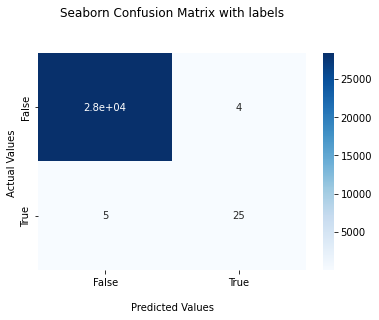

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Inference : Test set

In [ ]:
test = pd.read_csv('./test.csv') # Train
test_x = test.drop(columns=['ID'])

In [ ]:
test_pred = model.predict(test_x) # model prediction

## Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,ID,Class
0,AAAA0x1,1
1,AAAA0x2,1
2,AAAA0x5,1
3,AAAA0x7,1
4,AAAA0xc,1


In [ ]:
submit['Class'] = test_pred
submit.to_csv('./submission_EllipticEnvelope.csv', index=False)

In [ ]:
pd.read_csv('./submission_EllipticEnvelope.csv')['Class'].sum()

141897